# Kalman FilterによるARMAモデル時系列の推定

## 関連
- `state_system.ipynb`

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../module')
from utils import cum_std
from kalman_filters import LinearKalmanFilter as LKF
from kalman_filters import ExtendedKalmanFilter as EnKF


np.random.seed(0)

In [2]:
def generate_state_data(F, G, q, x_0, size):
    """
    モデルノイズは1次元を仮定
    """
    data = np.zeros((size, len(x_0)))
    x = x_0
    data[0] = x
    for i in range(1, size):
        x = F@x + G@np.random.normal(loc=0, scale=q, size=(1,))
        data[i] = x
    return data

def generate_obs_data(H, r, series, noise=True):
    """
    観測ノイズは1次元を仮定
    """
    obs = (H@series.T).T
    if noise:
        obs += np.random.normal(loc=0, scale=r, size=(len(series),1))
    return obs 

## 1. ARMAモデルによるデータの生成

In [3]:
# ARモデル
p = 3
a = np.array([-0.9, -0.7, -0.5]).reshape(p, 1)

# MAモデル
q = 3 
b = np.array([0.5, 0.5, 0.5])

N = max([p,q+1])
print(f'p = {p}, q = {q}, N = {N}')

# a, bを0拡張
if N > p:
    a_N = np.vstack([a, np.zeros(N-p)])
else:
    a_N = a

if N > q+1:
    b_N = np.hstack([b, np.zeros(N-q-2)])
else:
    b_N = b

# 状態遷移行列 (N, N)
F = np.block([a_N, np.vstack([np.eye(N-1), np.zeros((1, N-1))])])
print(f'F = \n{F}')

# ノイズ重み (N, 1), b_0=1を含む． 
G = np.array([1, *b_N]).reshape(N, 1)
print(f'G = \n{G}')

# 観測モデル (1, N)
H = np.block([1, np.zeros((1, N-1))])
print(f'H_ma = \n{H}')

# モデルノイズstd
sigma_m = 1
q = sigma_m
Q = np.array([q])
# 観測ノイズstd
sigma_o = 0.5
r = sigma_o
R = np.array([r])

p = 3, q = 3, N = 4
F = 
[[-0.9  1.   0.   0. ]
 [-0.7  0.   1.   0. ]
 [-0.5  0.   0.   1. ]
 [ 0.   0.   0.   0. ]]
G = 
[[1. ]
 [0.5]
 [0.5]
 [0.5]]
H_ma = 
[[1. 0. 0. 0.]]


In [4]:
# データを生成
sample_size = 100
x_0 = np.ones(N)
state_data = generate_state_data(F, G, Q, x_0, sample_size)
obs_data = generate_obs_data(H, R, state_data)
true = generate_obs_data(H, R, state_data, noise=False)

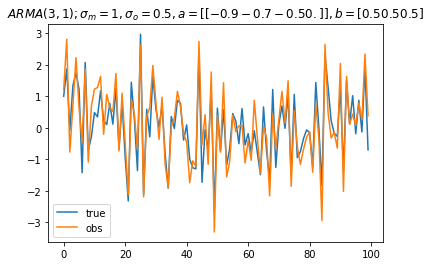

In [5]:
plt.plot(true, label='true')
plt.plot(obs_data, label='obs')
_ = plt.title(f'$ARMA({p},{q}); \sigma_m={sigma_m}, \sigma_o={sigma_o}, a={a_N.T}, b={b_N.T}$')
plt.legend()

## 2. Kalman Filterによる状態推定
Linear Kalman Filterを使う

条件
- 1.でデータを生成したARMAモデルをそのまま使う．
- 初期値は
    - $ x_0 $: state_dataからランダムに選ぶ．
    - $ P_0 $: $ 10 I $とする．


In [6]:
%%time
y = obs_data
x_0 = state_data[np.random.randint(0, sample_size)]
P_0 = 10*np.eye(N)
lkf = LKF(F, H, G, Q, R, y, x_0, P_0, alpha=1)
lkf.forward_estimation()

estimate_data = generate_obs_data(H, R, np.array(lkf.x), noise=False)

CPU times: user 5.31 ms, sys: 161 µs, total: 5.47 ms
Wall time: 5.38 ms


### 結果のplot

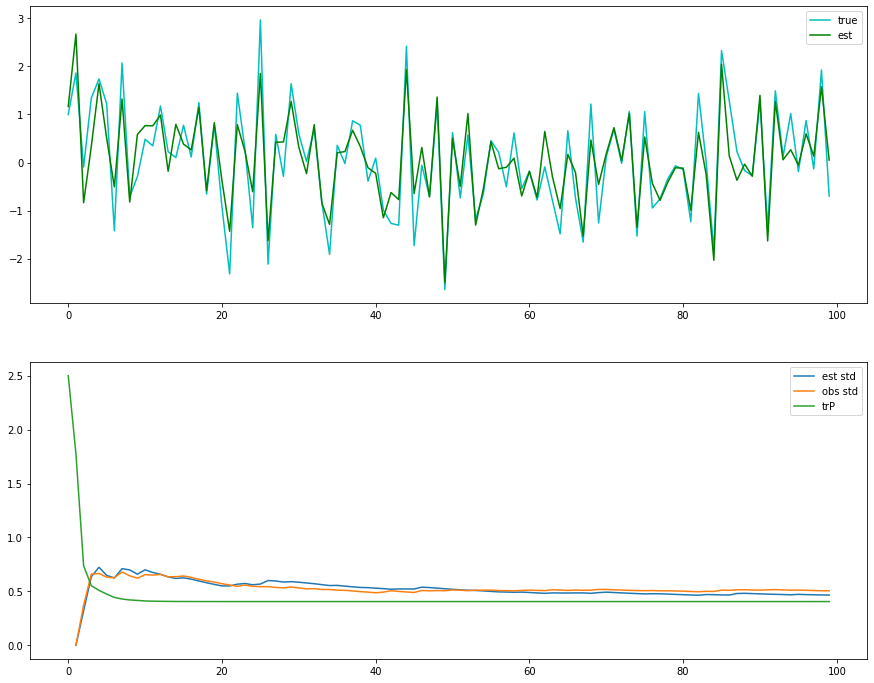

In [7]:
fig = plt.figure(figsize=(15,12))
ax1 = fig.add_subplot(2,1,1)
ax1.plot(true, label='true', color='c')
# ax1.plot(obs_data, label='obs')
ax1.plot(estimate_data, label='est', color='g')
# ax1.plot(true - estimate_data, label='error', color='r')
plt.legend()

ax2 = fig.add_subplot(2,1,2)
# ax2.plot(np.abs(true - estimate_data)) 本来はこれ
ax2.plot(cum_std(true - estimate_data), label='est std')
# ax2.plot(np.abs(true - obs_data)) 本来はこれ
ax2.plot(cum_std(true - obs_data), label='obs std')
ax2.plot(lkf.trP, label='trP')
plt.legend()

### 発展
非線形モデルに拡張したExtended Kalman Filterでも確認．

今，モデルが線形なので同様の結果が得られた．

In [8]:
%%time
M = lambda x,t: F@x
y = obs_data
x_0 = state_data[np.random.randint(0, sample_size)]
P_0 = 10*np.eye(N)
ekf = EnKF(M, H, G, Q, R, y[:], x_0, P_0, alpha=1)
ekf.forward_estimation()

ekf_estimate_data = generate_obs_data(H, R, np.array(ekf.x), noise=False)

CPU times: user 10.9 ms, sys: 1.75 ms, total: 12.6 ms
Wall time: 11.2 ms


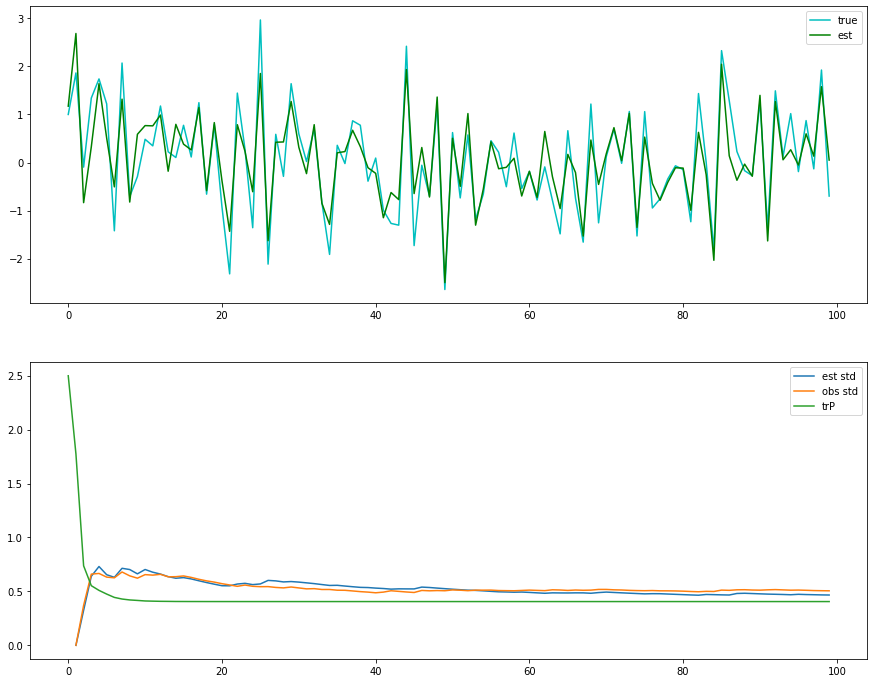

In [9]:
fig = plt.figure(figsize=(15,12))
ax1 = fig.add_subplot(2,1,1)
ax1.plot(true, label='true', color='c')
# ax1.plot(obs_data, label='obs')
ax1.plot(ekf_estimate_data, label='est', color='g')
# ax1.plot(true - ekf_estimate_data, label='error', color='r')
plt.legend()

ax2 = fig.add_subplot(2,1,2)
# ax2.plot(np.abs(true - ekf_estimate_data)) 本来はこれ
ax2.plot(cum_std(true - ekf_estimate_data), label='est std')
# ax2.plot(np.abs(true - obs_data)) 本来はこれ
ax2.plot(cum_std(true - obs_data), label='obs std')
ax2.plot(ekf.trP, label='trP')
plt.legend()